In [1]:
%%script false --no-raise-error

import os
bonmin_solver = SolverFactory(solver_name)

if not os.path.exists("/Users/dguittet/Projects/EnStore/ThermalTank/tests/tmp"):
    os.mkdir("/Users/dguittet/Projects/EnStore/ThermalTank/tests/tmp")
opt_file = "/Users/dguittet/Projects/EnStore/ThermalTank/tests/tmp/bonmin.opt"
with open(opt_file, "w") as f:
    f.write("ma27_liw_init_factor 50\n")
    f.write("ma27_la_init_factor 50\n")
    f.write("tol 1e-5\n")
    f.write("max_iter 50000\n")
    f.write("bonmin.time_limit 1800\n")
    f.write("bonmin.iteration_limit 80000\n")
bonmin_solver.options.option_file_name = opt_file

# m.obj = Objective(expr=m.peak * 1 + m.peak_tou * peak_tou_mult + summation(m.deriv_reg) * binary_enforce)
res = bonmin_solver.solve(m, tee=True)

if res.Solver.Status != 'ok':
    solve_log = idaeslog.getInitLogger("infeasibility", idaeslog.INFO, tag="properties")
    log_infeasible_constraints(m, logger=solve_log, tol=1e-2, log_expression=True, log_variables=True)

res = check_binary_variables(m, n)

if not res:
    print("Binary failure")

# Load up Models and Data

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import copy
importlib.reload(copy)
from thermal_tank.eplus_timeseries import *
from thermal_tank.run_mpc import *

bonmin_solver.options['tol'] = 1e-5
bonmin_solver.options['max_iter'] = 20000
bonmin_solver.options['bonmin.time_limit'] = 60 * 10
bonmin_solver.options['bonmin.iteration_limit'] = 40000

ipopt_solver.options['tol'] = 1e-8
ipopt_solver.options['max_iter'] = 25000

In [3]:
J_TO_KW = 1 / 60 * 1e-3

test_dir = Path("/Users/dguittet/Projects/EnStore/EnStore/test_files/icetes3/0000002")

df_orig = pd.read_parquet(test_dir / "base" / "eplusout.parquet")

n_tanks = 1
pv_kw = 0
use_tes_schedule = False

load = df_orig['Electricity:Facility [J](TimeStep)'].values * J_TO_KW * KW_SCALING
pv_gen = df_orig['PV LOAD CENTER:Electric Load Center Produced Electricity Rate [W](TimeStep)'].values * 1e-3 * KW_SCALING
pv_parasitic = (pv_gen * -1).clip(0)
# load += pv_parasitic
pv_gen = pv_gen.clip(0)

if n_tanks > 0 and not use_tes_schedule:
    load -= df_orig['CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)'].values * J_TO_KW * KW_SCALING
    df_orig['load'] = load
    df_orig['pv_gen'] = pv_gen
    df_orig['evap_T_diff'], df_orig['chiller_delta_T'] = calc_delta_Ts(df_orig)
    df_orig['cond_inlet_K'] = df_orig['CHW LOOP CHILLER:Chiller Condenser Inlet Temperature [C](TimeStep)'].values + 273.15
    df_orig['loop_inlet'] = df_orig['CHW LOOP CHILLER:Chiller Evaporator Inlet Temperature [C](TimeStep)'].values + 273.15
    df_orig['chiller_power'] = df_orig['CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)'].values * J_TO_KW * KW_SCALING
    df_orig['chw_outlet_temp'] = df_orig['CHW LOOP CHILLER:Chiller Evaporator Outlet Temperature [C](TimeStep)'].values + 273.15

In [5]:
df_5min, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T, zerod_i = smooth_df(df_orig)

In [7]:
from enstore.resources.controls.eplus_timeseries import remove_evap_T_outliers, calc_delta_Ts
sns.set_style('whitegrid')
df_eplus = pd.read_parquet("/Users/dguittet/Projects/EnStore/EnStore/unit_test/add_tes/base/eplusout.parquet")
df_eplus['evap_T_diff'] = calc_delta_Ts(df_eplus)[0]
df_5min = remove_evap_T_outliers(df_eplus)


(numpy.datetime64('2019-06-10T12:03:00.000000000'), 231840)

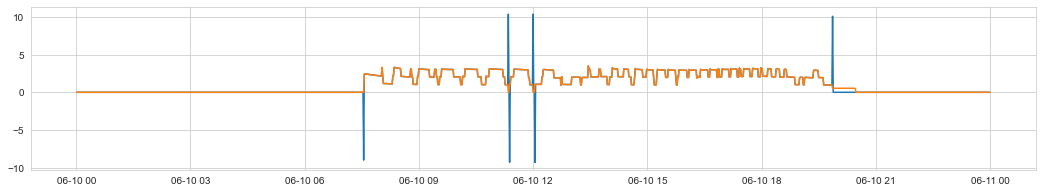

In [15]:
sns.set_style('whitegrid')
i = (229000 // 1440) * 1440 + 1440
fig, ax = plt.subplots(1, 1, figsize=(18, 3))
n_days = 1
plt.plot(df_orig.index.values[i:i + 1440 * n_days], df_orig['evap_T_diff'][i:i + 1440 * n_days])
plt.plot(df_5min.index.values[i:i + 1440 * n_days], evap_T_diff[i:i + 1440 * n_days])
df_orig.index.values[np.argmin(df_orig['evap_T_diff'][i:i + 1440 * n_days]) + i], i + 1440

# inlet_T[t+1] - outlet_T[t]

<Figure size 432x288 with 0 Axes>

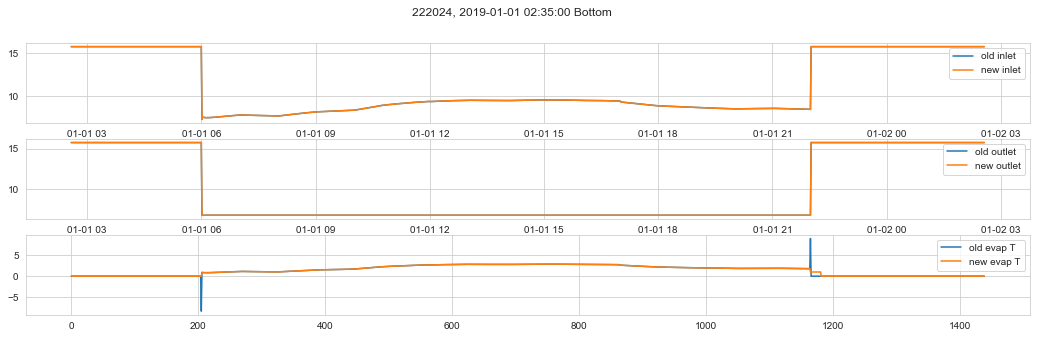

In [16]:
i = 222024

plt.figure()
ii = i // 1440 
day_slice = slice(i - 20, i +20)
day_slice = slice(ii, ii + 1440)
df_day_new = df_5min[day_slice]
df_day_orig = df_orig[day_slice]
fig, ax = plt.subplots(3, 1, figsize=(18, 5))
fig.suptitle(f"{i}, {df_day_orig.index[0]} Bottom")
ax[0].plot(df_day_orig['CHW LOOP CHILLER:Chiller Evaporator Inlet Temperature [C](TimeStep)'], label='old inlet')
ax[1].plot(df_day_orig['CHW LOOP CHILLER:Chiller Evaporator Outlet Temperature [C](TimeStep)'], label='old outlet')
ax[2].plot(df_day_orig['evap_T_diff'].values, label='old evap T')
ax[0].plot(df_day_new['CHW LOOP CHILLER:Chiller Evaporator Inlet Temperature [C](TimeStep)'], label='new inlet')
ax[1].plot(df_day_new['CHW LOOP CHILLER:Chiller Evaporator Outlet Temperature [C](TimeStep)'], label='new outlet')
ax[2].plot(evap_T_diff[day_slice], label='new evap T')
[a.legend() for a in ax]
plt.show()

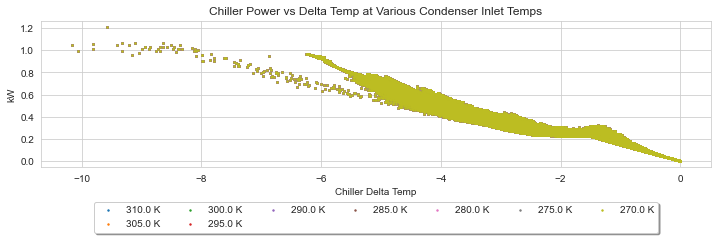

In [17]:
df_orig['cond_inlet_K_rounded'] = (df_orig['cond_inlet_K'] / 5).round() * 5
cond_inlet_vals = df_orig['cond_inlet_K_rounded'].unique()
cond_inlet_vals[::-1].sort()
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot()   
for cond_inlet_v in cond_inlet_vals:
    cond_inlet_df = df_orig[df_orig['cond_inlet_K_rounded'] == cond_inlet_v]
    loop_inlets = df_orig['loop_inlet'].values.tolist()
    chiller_outlets = df_orig['chw_outlet_temp'].values.tolist()
    chiller_diffs = df_orig['chiller_delta_T'].values.tolist()
    chiller_ps = df_orig['chiller_power'].values.tolist()
    ax.scatter(chiller_diffs, chiller_ps, label=f"{cond_inlet_v} K", s=2)
    # break
ax.set_xlabel('Chiller Delta Temp')
ax.set_ylabel('kW')
ax.set_title(f"Chiller Power vs Delta Temp at Various Condenser Inlet Temps")


# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=7)
plt.show()

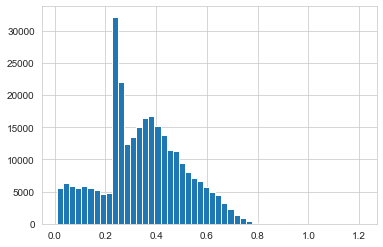

In [ ]:
from sklearn import linear_model

# Try Linear Regression with Features = Condenser Inlet Temp and Evaporator Temp Difference

chiller_ps = np.array(chiller_ps)
n, bins, _ = plt.hist(chiller_ps[chiller_ps > 1e-2], bins=50)
# n, bins, _ = plt.hist(chiller_ps, bins=50)

n_norm = n / sum(n)
weights = []
for p in chiller_ps:
    if p < 1e-2:
        weights.append(0)
    else:    
        ind = int(min(np.where(bins >= chiller_ps[0])[0])) - 1
        ind = max(0, ind)
        # weights.append(n_norm[ind] ** 4)
        weights.append(np.exp(n_norm[ind]*4)-1)

array(['cond_inlet^2', 'cond_inlet chiller_diffs', 'chiller_diffs^2'],
      dtype=object)

[ 0.         -0.03841539  0.2132953 ] 0.0
0.9498100532137109


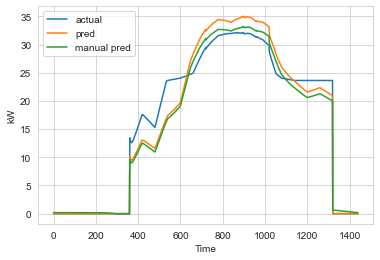

In [18]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# Try Linear Regression with Features = Condenser Inlet Temp and Evaporator Temp Difference

xs = [i for i  in zip(df_orig['cond_inlet_K'], df_orig['chiller_delta_T'])]
ys = df_orig['chiller_power'] / KW_SCALING

poly = PolynomialFeatures((2, 2), include_bias=False)
poly_features = poly.fit_transform(xs)
poly_features[:, 0] = 0
# poly_features[:, 3] = 0
display(poly.get_feature_names_out(("cond_inlet", "chiller_diffs")))

clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(poly_features, ys)
print(clf.coef_, clf.intercept_)
print(clf.score(poly_features, ys, [1 if p > 1 else 0 for p in ys]))

# Check performance for 1st day
ts = 0
day_slice = slice(ts * 1440, (ts + 1) * 1440)
x1 = df_orig['cond_inlet_K'][day_slice].values
x2 = df_orig['chiller_delta_T'][day_slice].values
X = np.array((x1, x2)).T
pred = clf.predict(poly.fit_transform(X))

plt.plot(df_orig["chiller_power"][day_slice].values / KW_SCALING, label="actual")
plt.plot(pred, label="pred")
plt.plot((x1 * 0.22952 - 10.747 * x2 - 66.418), label="manual pred")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()

# -0.04217111 * (evaps_short['cond_inlet'].values + 273.15) * (evaps_short['chiller_outlet_1'].values - evaps_short['loop_inlet_1']) - 0.34328665 * ((evaps_short['chiller_outlet_1'].values - evaps_short['loop_inlet_1'])) **2

# chillerP = df_orig['chiller_power']
# chillerP_pred = -0.04217111 * (df_orig['cond_inlet_K'].values) * (df_orig['chiller_delta_T']) - 0.34328665 * (df_orig['chiller_delta_T']) **2
# chiller_p_diff = (chillerP_pred - chillerP)
# n, bins, _ = plt.hist(chiller_p_diff, bins=50)

[  0.09676267 -12.05053756] -28.000299883513044
0.9819320133793951


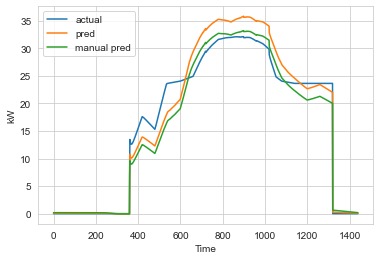

In [19]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# Try Linear Regression with Features = Condenser Inlet Temp and Evaporator Temp Difference

clf = linear_model.LinearRegression(fit_intercept=True)
clf.fit(xs, ys)
print(clf.coef_, clf.intercept_)
# print(clf.score(xs, ys, [1 if p > 1 else 0 for p in ys]))
print(clf.score(xs, ys))

# Check performance for 1st day
ts = 0
day_slice = slice(ts * 1440, (ts + 1) * 1440)
x1 = df_orig['cond_inlet_K'][day_slice].values
x2 = df_orig['chiller_delta_T'][day_slice].values
X = np.array((x1, x2)).T
pred = clf.predict(X)

plt.plot(df_orig["chiller_power"][day_slice].values / KW_SCALING, label="actual")
plt.plot(pred, label="pred")
plt.plot((x1 * 0.22952 - 10.747 * x2 - 66.418), label="manual pred")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()

# -0.04217111 * (evaps_short['cond_inlet'].values + 273.15) * (evaps_short['chiller_outlet_1'].values - evaps_short['loop_inlet_1']) - 0.34328665 * ((evaps_short['chiller_outlet_1'].values - evaps_short['loop_inlet_1'])) **2

# chillerP = df_orig['chiller_power']
# chillerP_pred = -0.04217111 * (df_orig['cond_inlet_K'].values) * (df_orig['chiller_delta_T']) - 0.34328665 * (df_orig['chiller_delta_T']) **2
# chiller_p_diff = (chillerP_pred - chillerP)
# n, bins, _ = plt.hist(chiller_p_diff, bins=50)

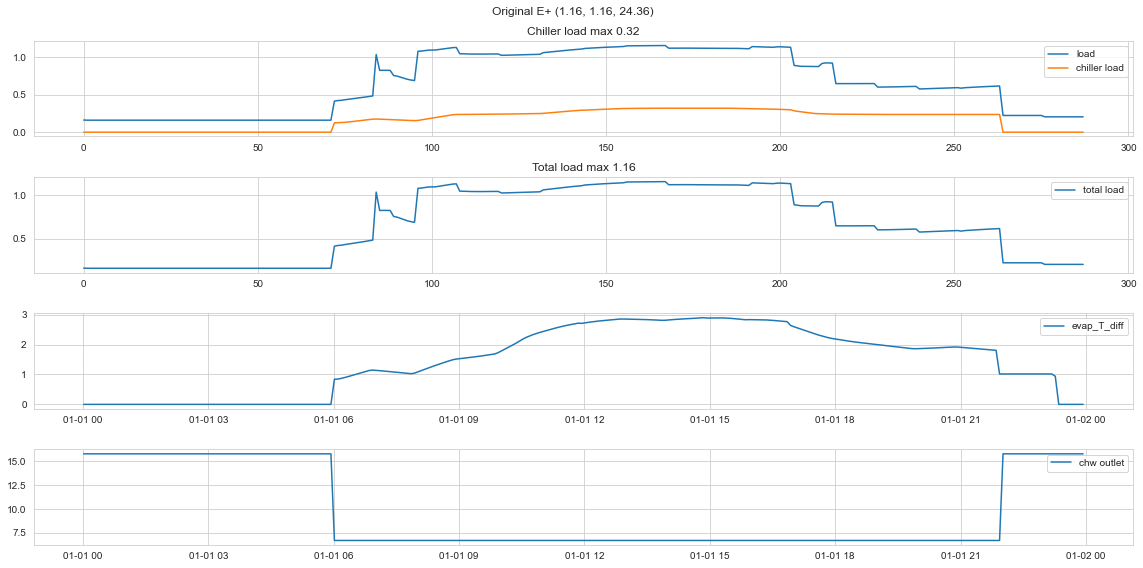

In [ ]:
sns.set_style("whitegrid")
start_ts = 0
peak_tou_mult = 20
dt_hr = 1 / 12
mins_per_ts = int(60 * dt_hr)

chiller_schedule = make_chiller_schedule(dt_hr)
df_resampled, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T = get_resampled_df(df_orig, dt_hr)
df_5min, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T, zerod_i = smooth_df(df_resampled)

df = df_5min
fig, ax = plt.subplots(4, 1, figsize=(16, 8))
time = slice(0, int(1/dt_hr) * 24)
orig_ch_load = df['chiller_power'].values[time]
orig_bldg_load = df['load'].values[time]
orig_load = orig_ch_load + orig_bldg_load
ax[0].plot(orig_load, label="load")
ax[0].set_title(f"Chiller load max {round(max(orig_ch_load), 2)}")
ax[0].plot(orig_ch_load, label="chiller load")
ax[1].plot(orig_load, label="total load")
ax[1].set_title(f"Total load max {round(max(orig_load), 2)}")
ax[2].plot(df['evap_T_diff'][time], label="evap_T_diff")
ax[3].plot(df['chw_outlet_temp'][time] - 273.15, label="chw outlet")

[a.legend() for a in ax]
orig_peak = round(max(orig_load), 2)
orig_peak_tou = round(max(orig_load[i] for i in range(13 * int(1/dt_hr), 19 * int(1/dt_hr))), 2)
plt.suptitle(f"Original E+ {orig_peak, orig_peak_tou, round(orig_peak + orig_peak_tou * 20, 2)}")
plt.tight_layout()

# Start 10-min Optimization

In [ ]:
start_ts = 0
peak_tou_mult = 20
dt_hr = 1 / 6
mins_per_ts = int(60 * dt_hr)

chiller_schedule = make_chiller_schedule(dt_hr)
df_resampled, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T = get_resampled_df(df_orig, dt_hr)
df_10min, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T, zerod_i = smooth_df(df_resampled)

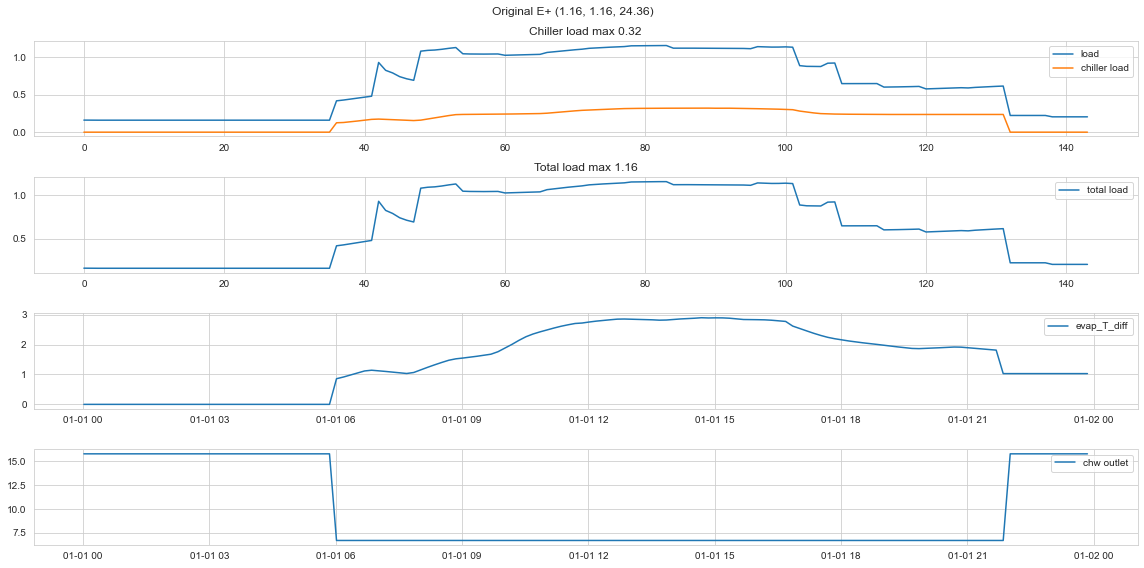

In [ ]:
df = df_10min
fig, ax = plt.subplots(4, 1, figsize=(16, 8))
time = slice(0, int(1/dt_hr) * 24)
orig_ch_load = df['chiller_power'].values[time]
orig_bldg_load = df['load'].values[time]
orig_load = orig_ch_load + orig_bldg_load
ax[0].plot(orig_load, label="load")
ax[0].set_title(f"Chiller load max {round(max(orig_ch_load), 2)}")
ax[0].plot(orig_ch_load, label="chiller load")
ax[1].plot(orig_load, label="total load")
ax[1].set_title(f"Total load max {round(max(orig_load), 2)}")
ax[2].plot(df['evap_T_diff'][time], label="evap_T_diff")
ax[3].plot(df['chw_outlet_temp'][time] - 273.15, label="chw outlet")

[a.legend() for a in ax]
orig_peak = round(max(orig_load), 2)
orig_peak_tou = round(max(orig_load[i] for i in range(13 * int(1/dt_hr), 19 * int(1/dt_hr))), 2)
plt.suptitle(f"Original E+ {orig_peak, orig_peak_tou, round(orig_peak + orig_peak_tou * 20, 2)}")
plt.tight_layout()

Init (1.11, 1.11, 23.310000000000002)
First IPOPT solve (0.95, 0.9, 18.95) 19.04328769299398
Second IPOPT solve (1.18, 1.18, 24.779999999999998) 24.788148702459807
BONMIN solve (1.18, 1.18, 24.779999999999998)


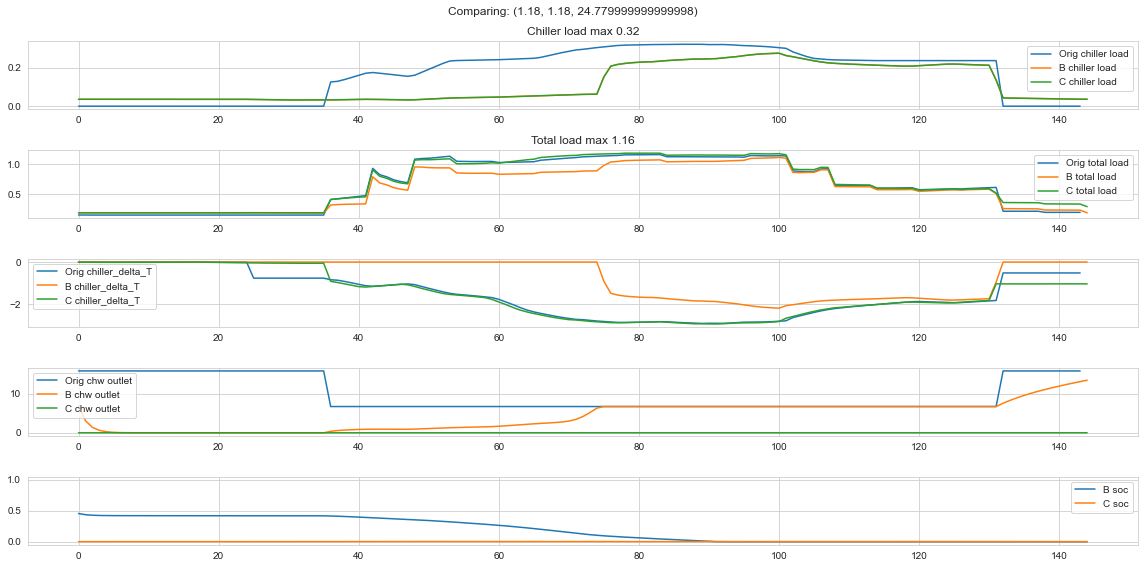

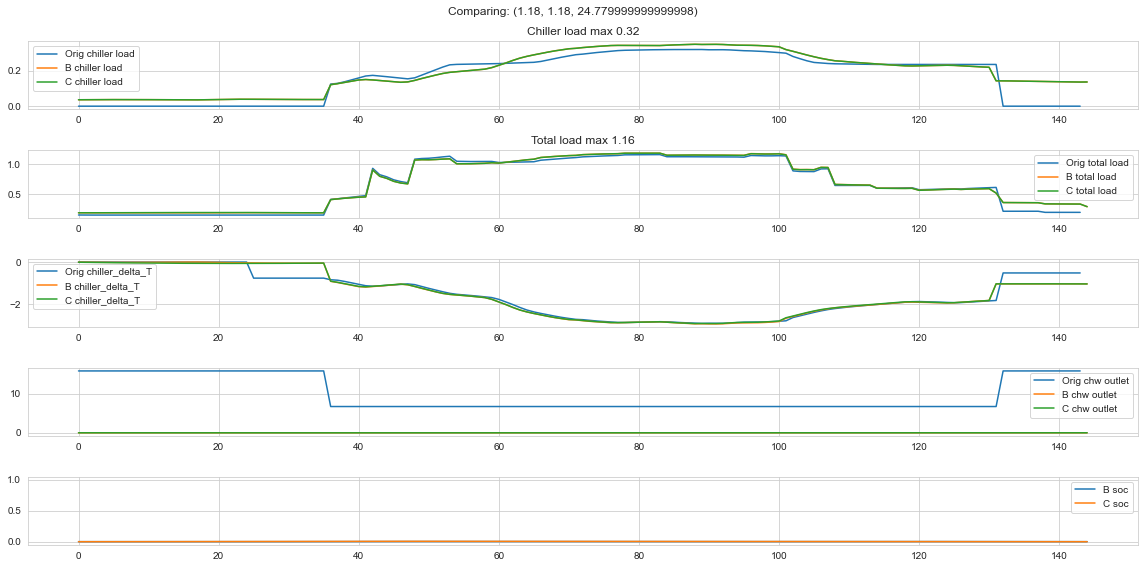

In [ ]:
# Try with original chiller outlet temperature set point
m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
# prev_outlet_temp = chw_outlet_temp[len(chw_outlet_temp) - 1]
prev_outlet_temp = chw_outlet_temp[0] + 273.15
# prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=1, inlet_temp_mult=0, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
bonmin_solver.options['bonmin.algorithm'] = 'B-BB'
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=100, binary_enforce_2=10, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-BB'
bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Init (2.21, 0.9, 20.21)
First IPOPT solve (1.12, 0.95, 20.12) 20.73035478295742
Second IPOPT solve (1.12, 0.98, 20.720000000000002) 22.933264213258184
Bonmin 1.8.8 using Cbc 2.10.4 and Ipopt 3.12.12
bonmin: tol=1e-05
max_iter=50000
bonmin.time_limit=600
bonmin.iteration_limit=100000000
bonmin.algorithm=B-Hyb
tol=1e-05
max_iter=50000
bonmin.time_limit=600
bonmin.iteration_limit=100000000
bonmin.algorithm=B-Hyb


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 22.160969     1485 13.770855     build initial OA
NLP3017W OA o

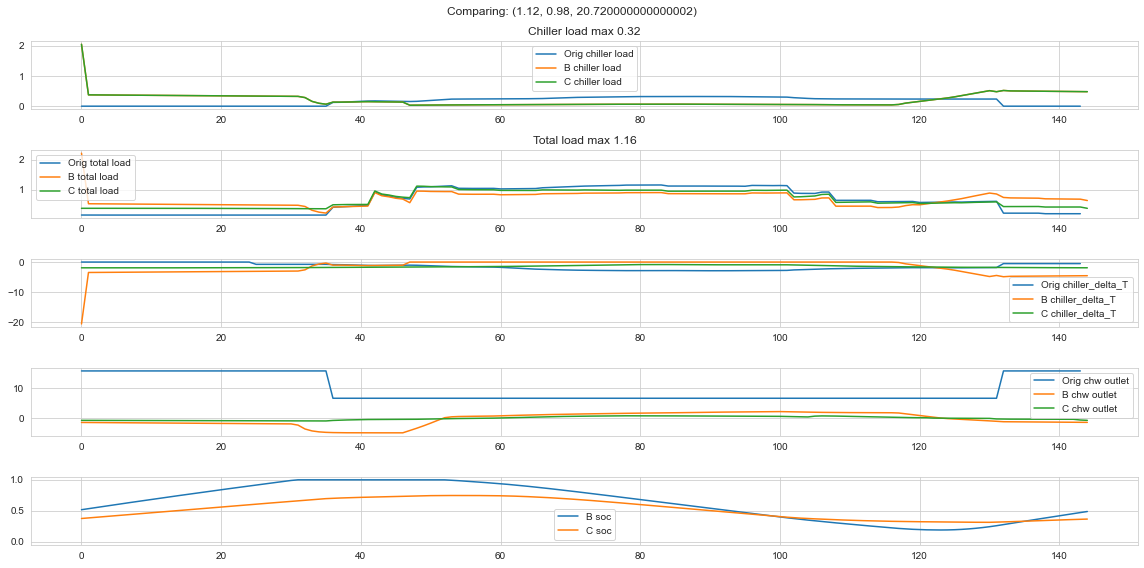

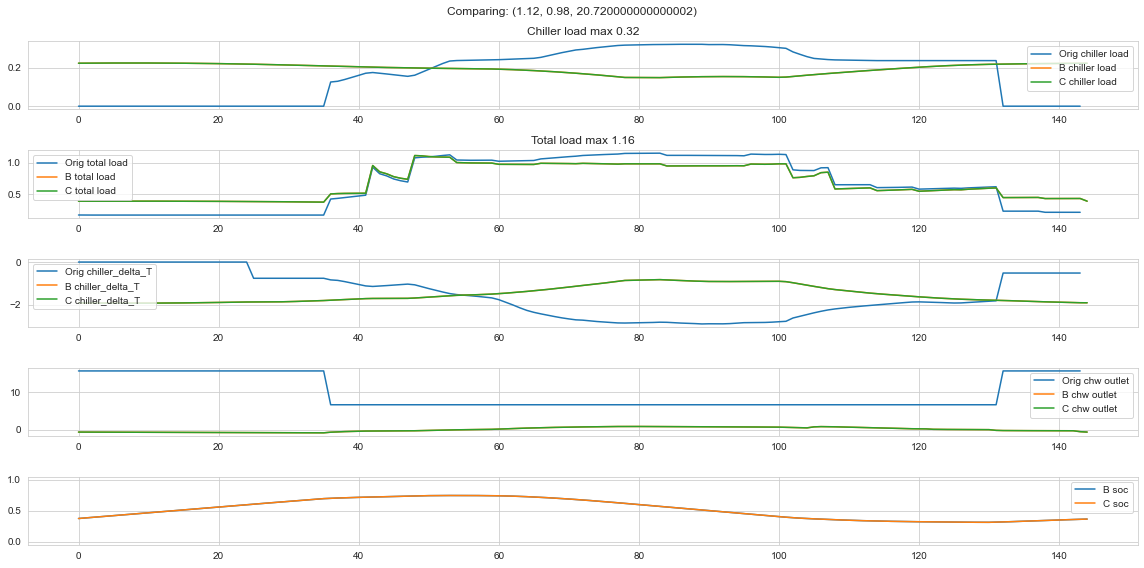

In [ ]:
# Try with set point
m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
# prev_outlet_temp = chw_outlet_temp[len(chw_outlet_temp) - 1]
prev_outlet_temp = chw_outlet_temp[0] + 273.15
# prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=1, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
bonmin_solver.options['bonmin.algorithm'] = 'B-BB'
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_1st_enforce=0.1, deriv_2nd_enforce=0, binary_enforce_2=1e-1, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.options['max_iter'] = 50000
bonmin_solver.options['bonmin.iteration_limit'] = 100000000
bonmin_solver.solve(m, tee=True)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

First IPOPT solve (0.95, 0.9, 18.95) 19.043652336871652
Second IPOPT solve (0.95, 0.9, 18.95) 19.096869292631403
Bonmin 1.8.8 using Cbc 2.10.4 and Ipopt 3.12.12
bonmin: tol=1e-05
max_iter=50000
bonmin.time_limit=600
bonmin.iteration_limit=10000000
bonmin.algorithm=B-Hyb
tol=1e-05
max_iter=50000
bonmin.time_limit=600
bonmin.iteration_limit=10000000
bonmin.algorithm=B-Hyb


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 19.097033     1139 9.75039     build initial OA
NLP3017W OA on non-convex constraint is very experiment

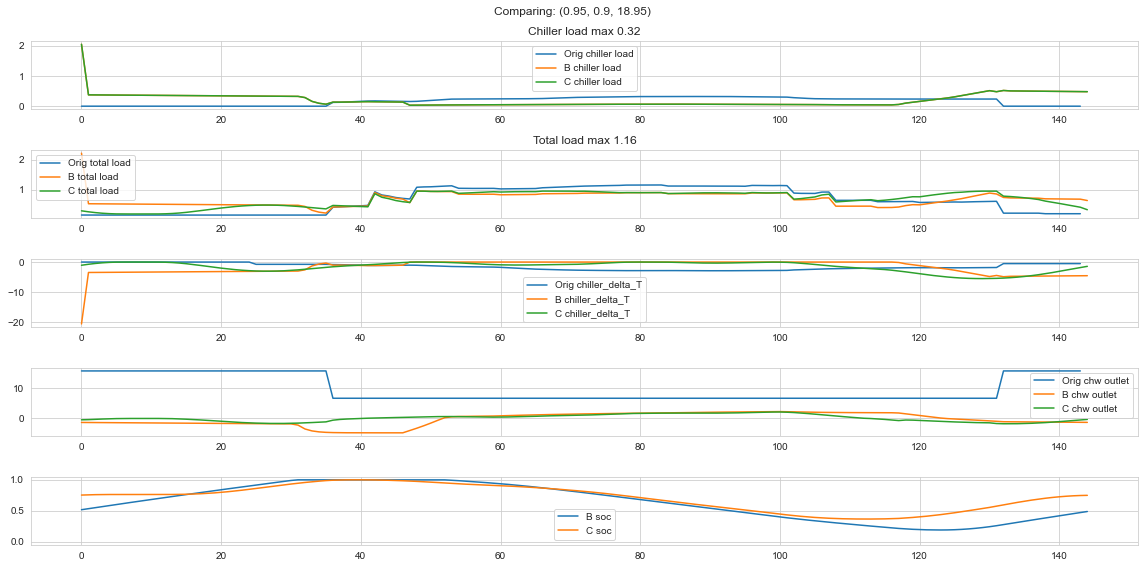

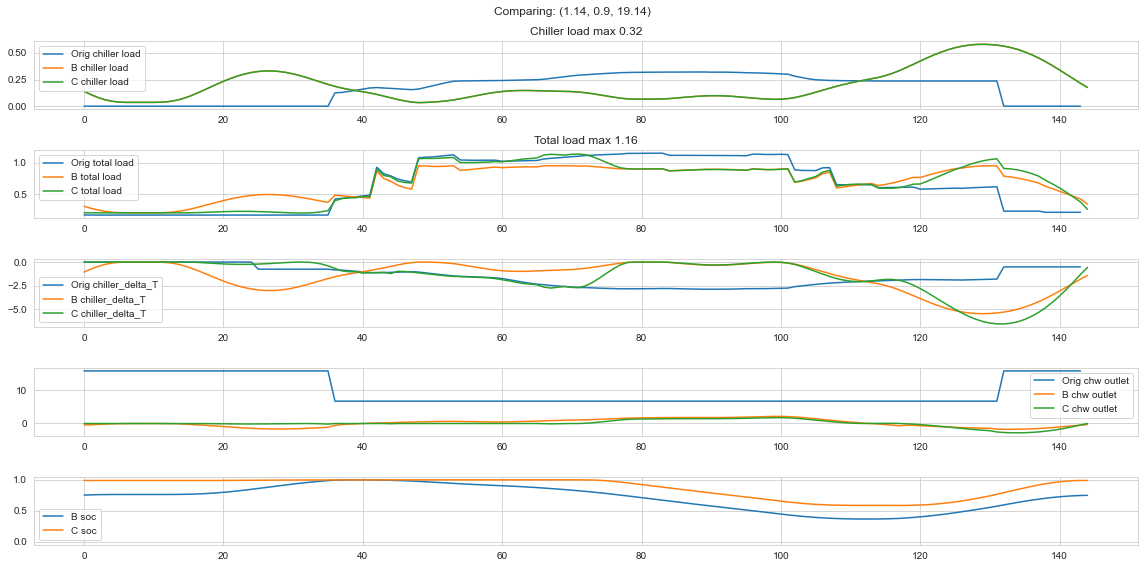

In [ ]:
relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_1st_enforce=0.001, deriv_1st_enforce=0.001, binary_enforce_2=1e-2, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.options['max_iter'] = 50000
bonmin_solver.options['bonmin.iteration_limit'] = 10000000
bonmin_solver.solve(m, tee=True)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Bonmin 1.8.8 using Cbc 2.10.4 and Ipopt 3.12.12
bonmin: tol=1e-05
max_iter=10000
bonmin.time_limit=600
bonmin.iteration_limit=10000000
bonmin.algorithm=B-Hyb
tol=1e-05
max_iter=10000
bonmin.time_limit=600
bonmin.iteration_limit=10000000
bonmin.algorithm=B-Hyb


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 19.544893     2009 13.749985     build initial OA
NLP3017W OA on non-convex constraint is very experimental.
NLP0014I             2         OPT 19.510541      213 1.50865         FP for MINLP
Cbc0031I 104 added rows 

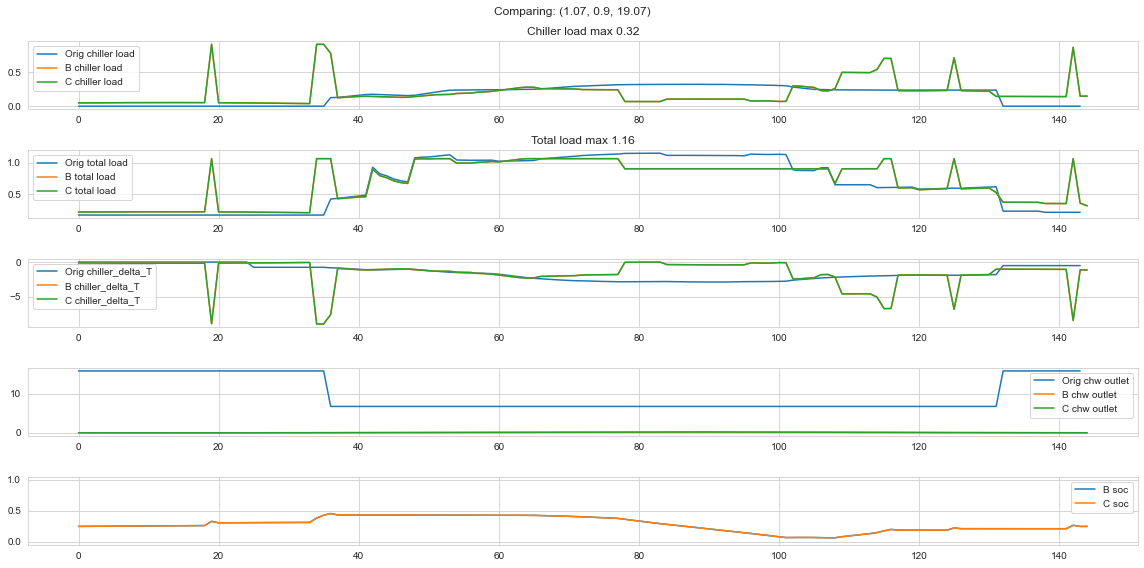

In [ ]:
bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.options['max_iter'] = 10000
bonmin_solver.options['bonmin.iteration_limit'] = 10000000
bonmin_solver.solve(m, tee=True)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Init (1.17, 0.93, 19.770000000000003)
First IPOPT solve (0.95, 0.9, 18.95) 19.04328724607084
Second IPOPT solve (1.07, 0.9, 19.07) 19.50869906511006
    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: bonmin\x3a Optimization interrupted on limit.
BONMIN solve (1.07, 0.9, 19.07)


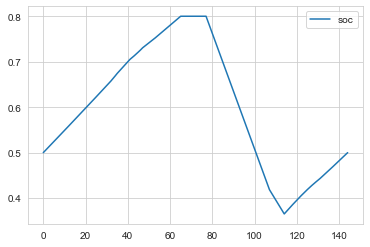

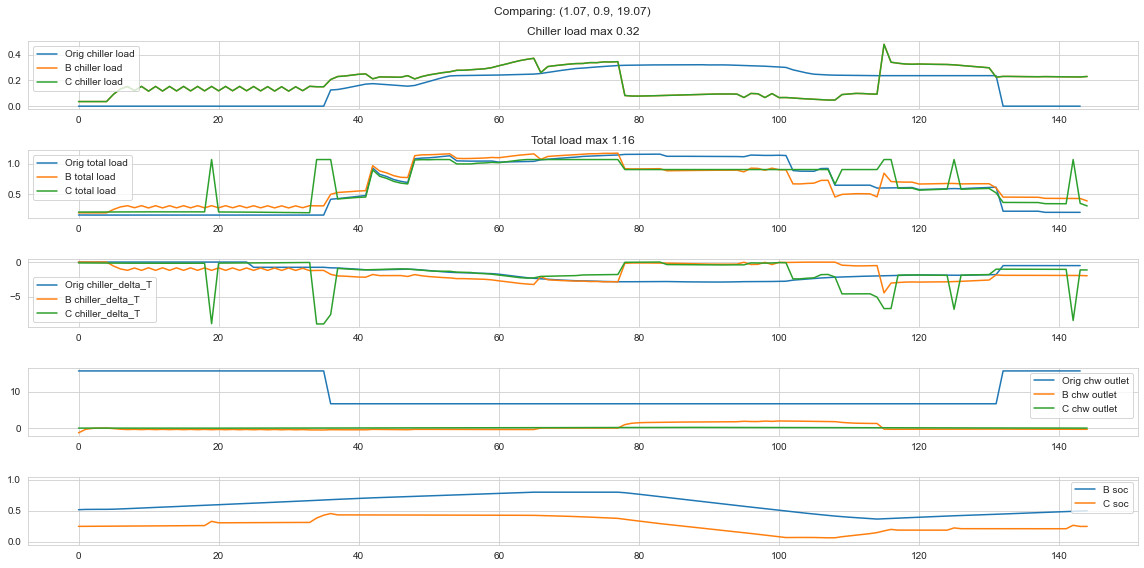

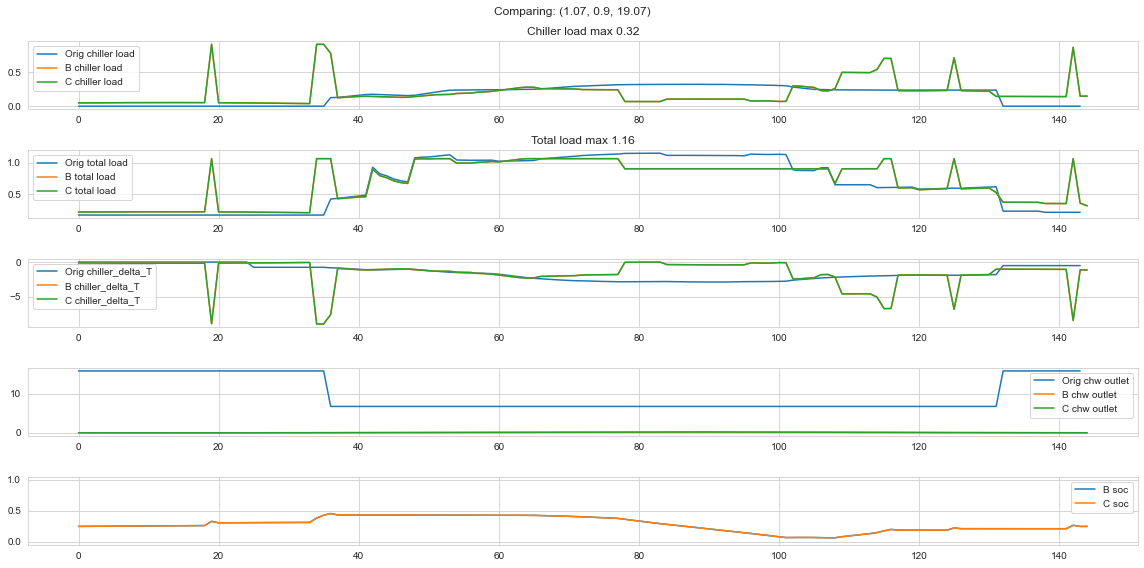

In [ ]:
# Try with SOC
socs = make_soc(m, start_ts, init_data['chiller_p'], init_data['bldg_p'], 11, 18)

m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
# prev_outlet_temp = chw_outlet_temp[len(chw_outlet_temp) - 1]
# prev_outlet_temp = chw_outlet_temp[0]
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=0, soc_mult=1, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
bonmin_solver.options['bonmin.algorithm'] = 'B-BB'
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=socs)

print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=10, binary_enforce_2=1e-2, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Init (1.18, 1.18, 24.779999999999998)
First IPOPT solve (0.96, 0.9, 18.96) 19.048393819804108
Second IPOPT solve (1.07, 0.9, 19.07) 19.370458237509485
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: bonmin\x3a Infeasible problem
BONMIN solve (1.07, 0.9, 19.07)


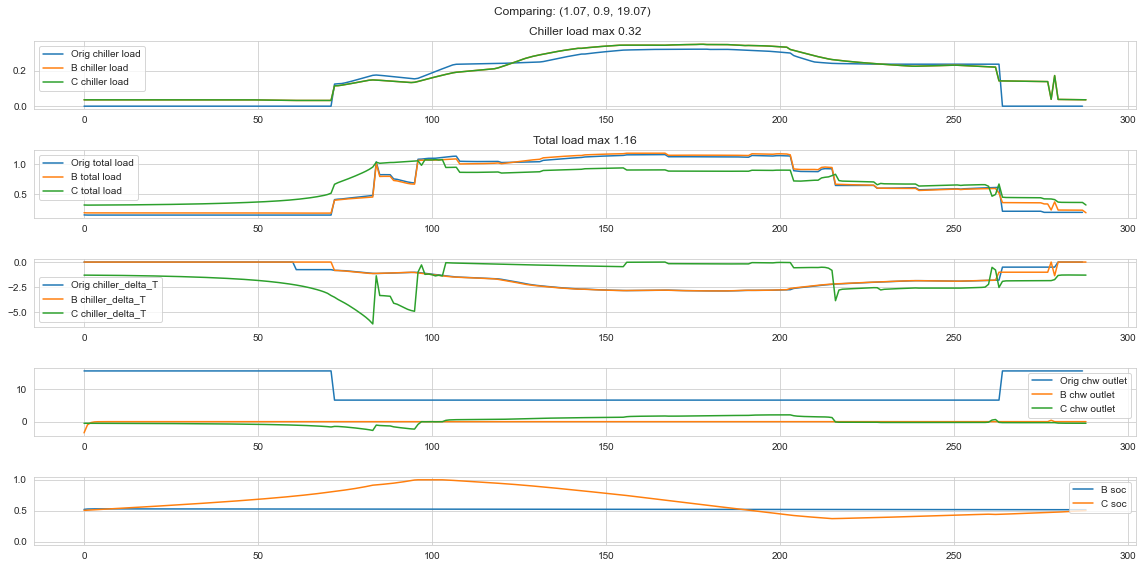

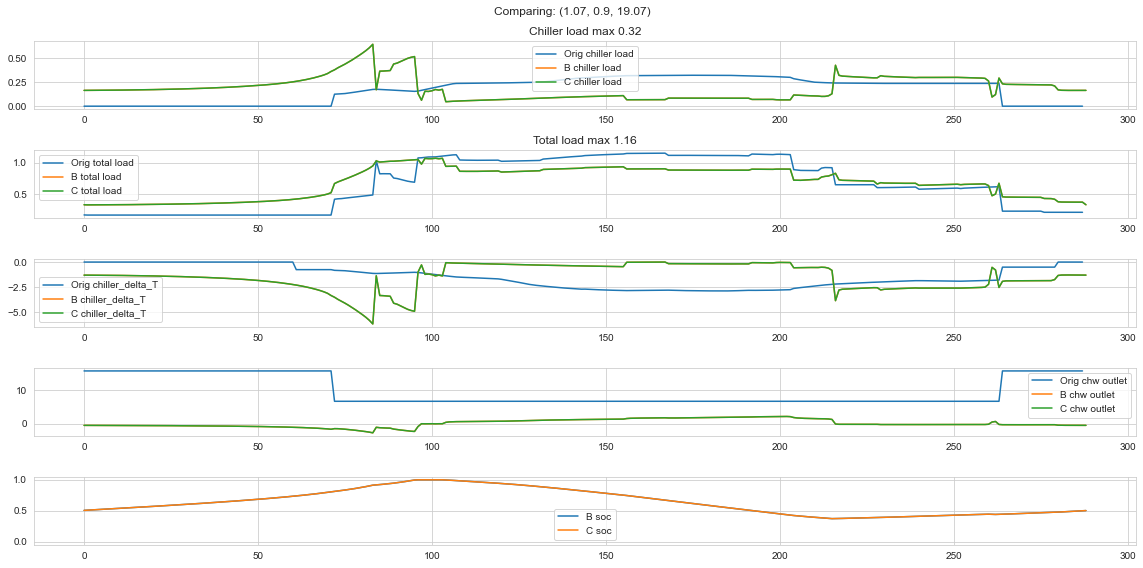

In [ ]:
# Try solving with no TES

m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
prev_outlet_temp = chw_outlet_temp[0]
# prev_outlet_temp = chw_outlet_temp[0]
# prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=1, inlet_temp_mult=0, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=10)
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)

print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=0, binary_enforce_2=150, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

# Try 15-min Optimization

In [ ]:
start_ts = 0
peak_tou_mult = 20
dt_hr = 1 / 4
mins_per_ts = int(60 * dt_hr)

chiller_schedule = make_chiller_schedule(dt_hr)
df_resampled, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T = get_resampled_df(df_orig, dt_hr)
df_15, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T, zerod_i = smooth_df(df_resampled)

In [ ]:
len(df_orig)

525600

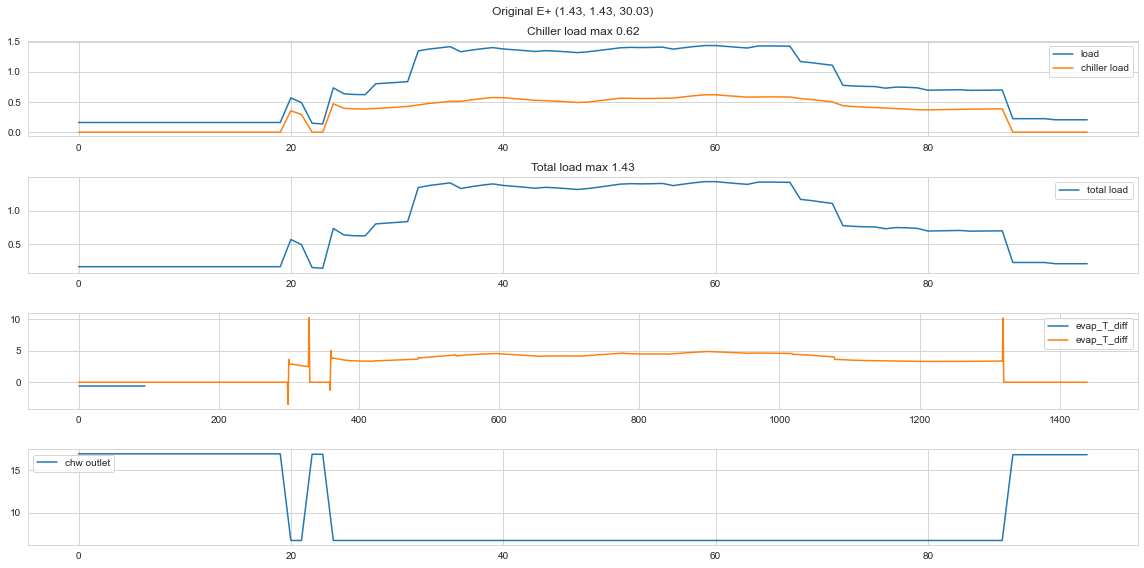

In [ ]:
df = df_15
start_ts = 96 * 154
fig, ax = plt.subplots(4, 1, figsize=(16, 8))
time = slice(start_ts, start_ts + int(1/dt_hr) * 24)
orig_ch_load = df['chiller_power'].values[time]
orig_bldg_load = df['load'].values[time]
orig_load = orig_ch_load + orig_bldg_load
ax[0].plot(orig_load, label="load")
ax[0].set_title(f"Chiller load max {round(max(orig_ch_load), 2)}")
ax[0].plot(orig_ch_load, label="chiller load")
ax[1].plot(orig_load, label="total load")
ax[1].set_title(f"Total load max {round(max(orig_load), 2)}")
ax[2].plot(df['evap_T_diff'][time].values, label="evap_T_diff")
ax[2].plot(df_orig['evap_T_diff'][start_ts * 15: start_ts * 15 + 1440].values, label="evap_T_diff")
ax[3].plot(df['chw_outlet_temp'][time].values - 273.15, label="chw outlet")

[a.legend() for a in ax]
orig_peak = round(max(orig_load), 2)
orig_peak_tou = round(max(orig_load[i] for i in range(13 * int(1/dt_hr), 19 * int(1/dt_hr))), 2)
plt.suptitle(f"Original E+ {orig_peak, orig_peak_tou, round(orig_peak + orig_peak_tou * 20, 2)}")
plt.tight_layout()

In [ ]:
df.columns

Index(['PV LOAD CENTER:Electric Load Center Produced Electricity Rate [W](TimeStep)',
       'PV LOAD CENTER:Electric Load Center Supplied Electricity Rate [W](TimeStep)',
       'PV LOAD CENTER:Electric Load Center Requested Electricity Rate [W](TimeStep)',
       'CHW LOOP CHILLER:Chiller Electricity Energy [J](TimeStep)',
       'CHW LOOP CHILLER:Chiller Evaporator Inlet Temperature [C](TimeStep)',
       'CHW LOOP CHILLER:Chiller Evaporator Outlet Temperature [C](TimeStep)',
       'CHW LOOP CHILLER:Chiller Condenser Inlet Temperature [C](TimeStep)',
       'Electricity:Facility [J](TimeStep)',
       'ElectricitySurplusSold:Facility [J](TimeStep)',
       'ElectricityPurchased:Facility [J](TimeStep)',
       'ElectricityProduced:Facility [J](TimeStep)',
       'EVLoad:ExteriorEquipment:Electricity [J](TimeStep)',
       'NaturalGas:Facility [J](TimeStep)', 'load', 'pv_gen', 'evap_T_diff',
       'chiller_delta_T', 'cond_inlet_K', 'loop_inlet', 'chiller_power',
       'chw_outlet_t

Init (0.96, 0.9, 2.76)
First IPOPT solve (0.96, 0.9, 2.76) 2.7567671547801993
Second IPOPT solve (0.96, 0.9, 2.76) 108.54018564522315
    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: bonmin\x3a Optimization interrupted on limit.
BONMIN solve (0.96, 0.9, 2.76)


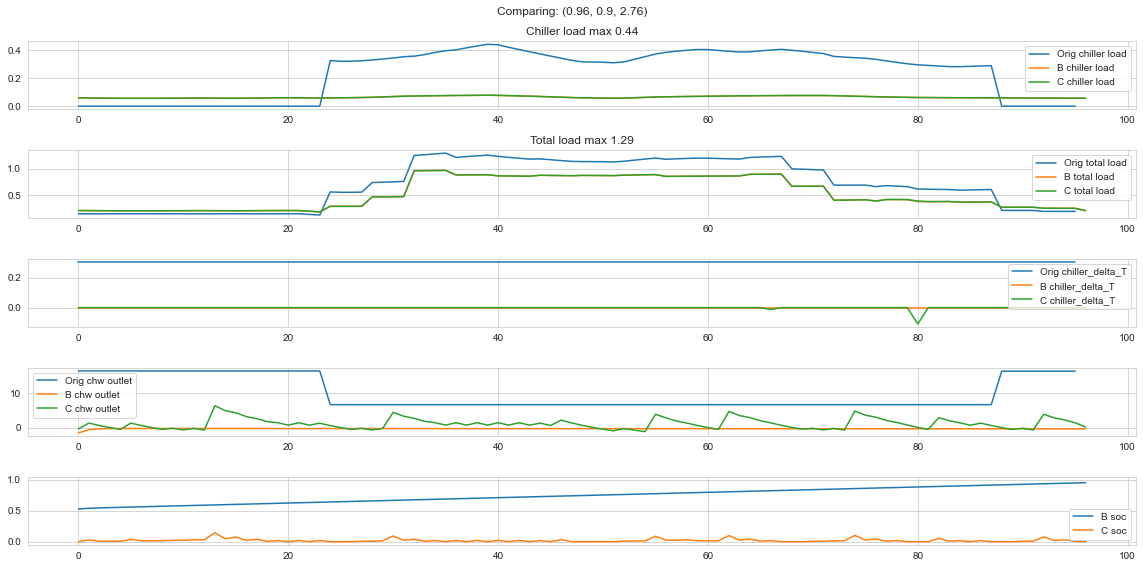

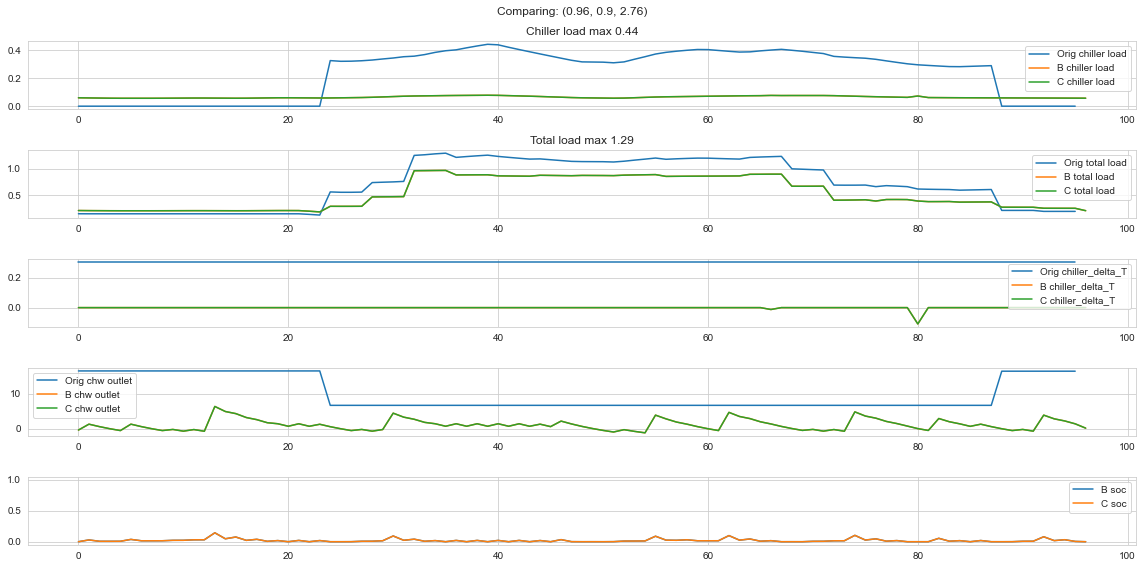

In [ ]:
# Try with set point
start_ts = 96 * 150
m, orig_data = make_model(df, start_ts, 2, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
# prev_outlet_temp = chw_outlet_temp[len(chw_outlet_temp) - 1]
# prev_outlet_temp = chw_outlet_temp[0]
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=1, inlet_temp_mult=0, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
bonmin_solver.options['bonmin.algorithm'] = 'B-BB'
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_1st_enforce=0, deriv_2nd_enforce=0, binary_enforce_2=10, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.solve(m)
sol_data = get_data(m)
print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Init (1.07, 1.07, 22.470000000000002)
First IPOPT solve (0.95, 0.9, 18.95) 19.039151857548383
Second IPOPT solve (0.95, 0.9, 18.95) 29.039151857453163
BONMIN solve (0.95, 0.9, 18.95)


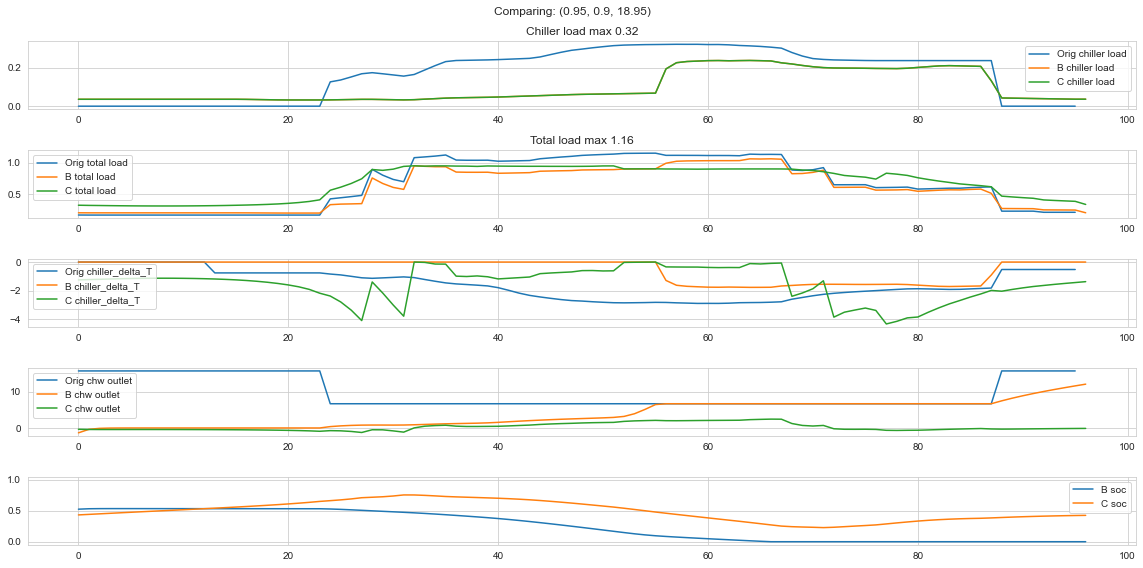

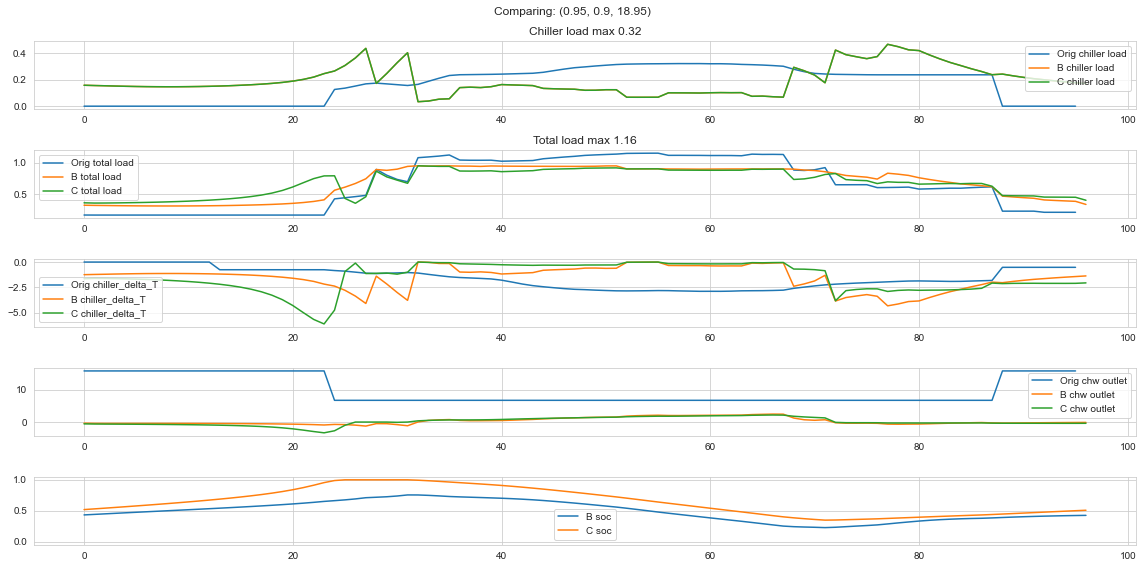

In [ ]:
# Try with set point
m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
# prev_outlet_temp = chw_outlet_temp[len(chw_outlet_temp) - 1]
# prev_outlet_temp = chw_outlet_temp[0]
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=1, inlet_temp_mult=0, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
bonmin_solver.options['bonmin.algorithm'] = 'B-BB'
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_1st_enforce=0, deriv_2nd_enforce=0, binary_enforce_2=10, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.options['bonmin.algorithm'] = 'B-Hyb'
bonmin_solver.solve(m)
sol_data = get_data(m)
print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Init (1.2, 0.92, 19.6)
First IPOPT solve (0.95, 0.9, 18.95) 19.03915186149075
Second IPOPT solve (1.18, 1.18, 24.779999999999998) 24.78522864598185
BONMIN solve (1.18, 1.18, 24.779999999999998)


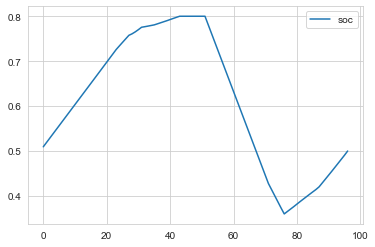

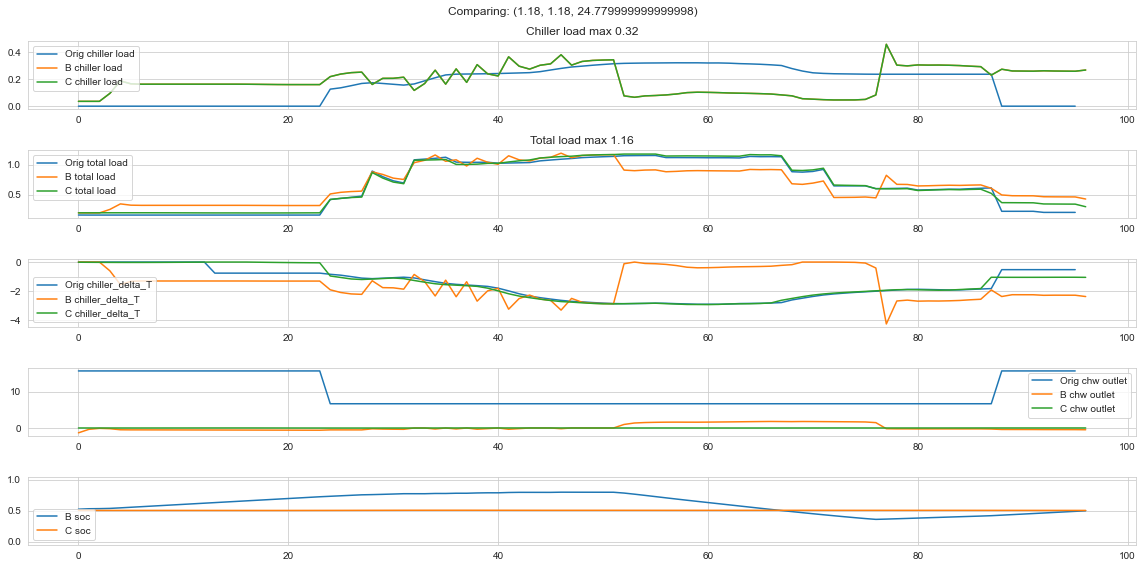

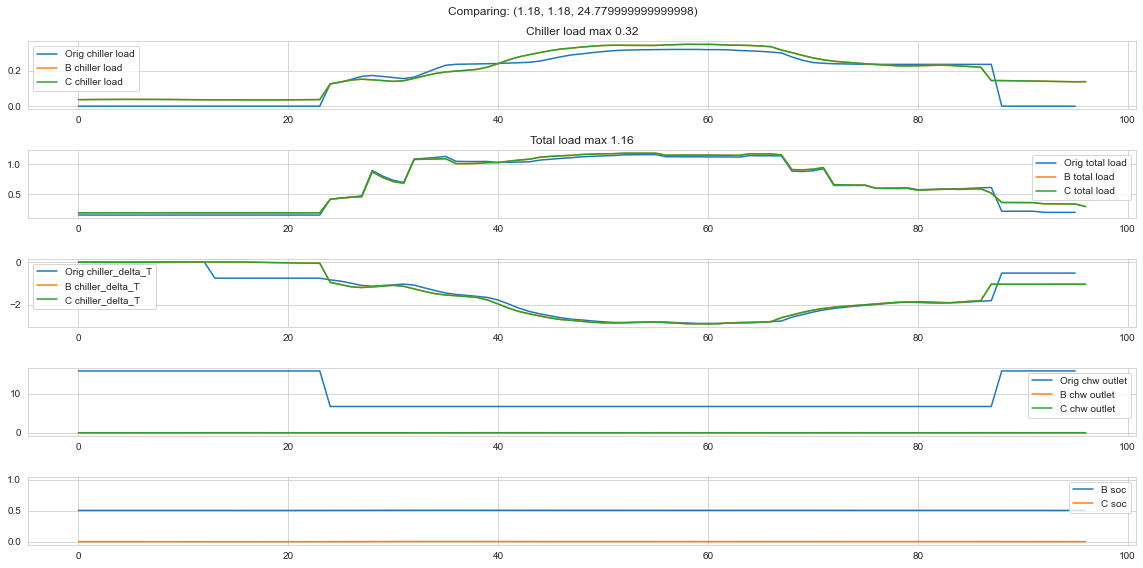

In [ ]:
# Try with SOC
socs = make_soc(m, start_ts, init_data['chiller_p'], init_data['bldg_p'], 11, 18)

m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
# prev_outlet_temp = chw_outlet_temp[len(chw_outlet_temp) - 1]
# prev_outlet_temp = chw_outlet_temp[0]
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=0, soc_mult=1, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=socs)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=10, binary_enforce_2=10, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)
print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

In [ ]:
# Try solving with no TES

m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts, run_fbbt=False)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
prev_outlet_temp = chw_outlet_temp[0] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=1, inlet_temp_mult=0, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=1, tank_flow_fraction_mult=10)
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=5, binary_enforce_2=10, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

TypeError: make_model() got an unexpected keyword argument 'fbbt'

Init (1.12, 1.12, 23.520000000000003)
First IPOPT solve (0.95, 0.9, 18.95) 19.03915186647529
Second IPOPT solve (1.18, 1.18, 24.779999999999998) 24.78003485100614
BONMIN solve (1.18, 1.18, 24.779999999999998)


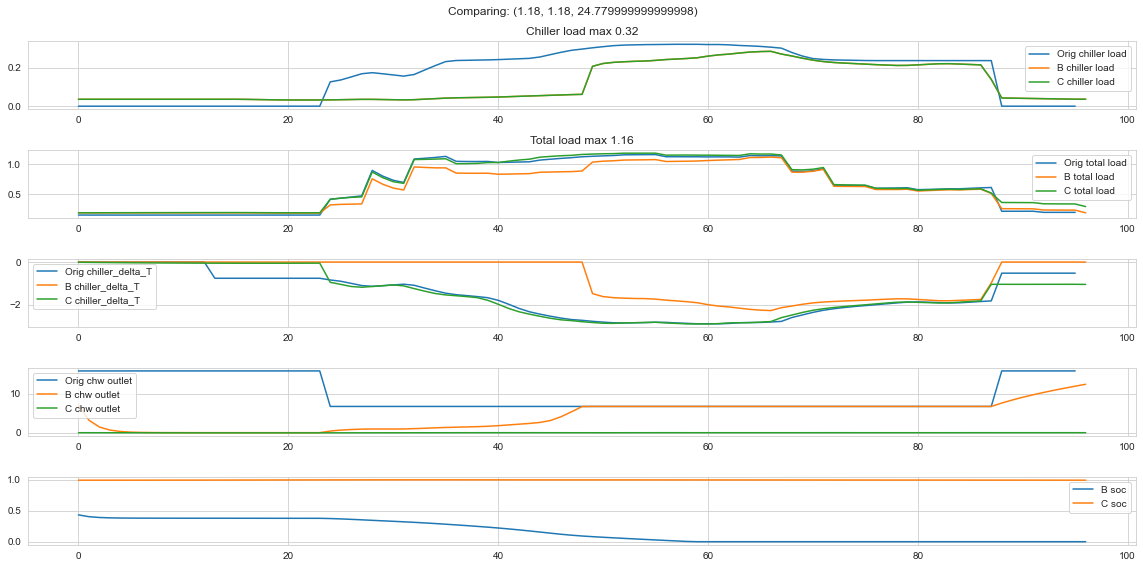

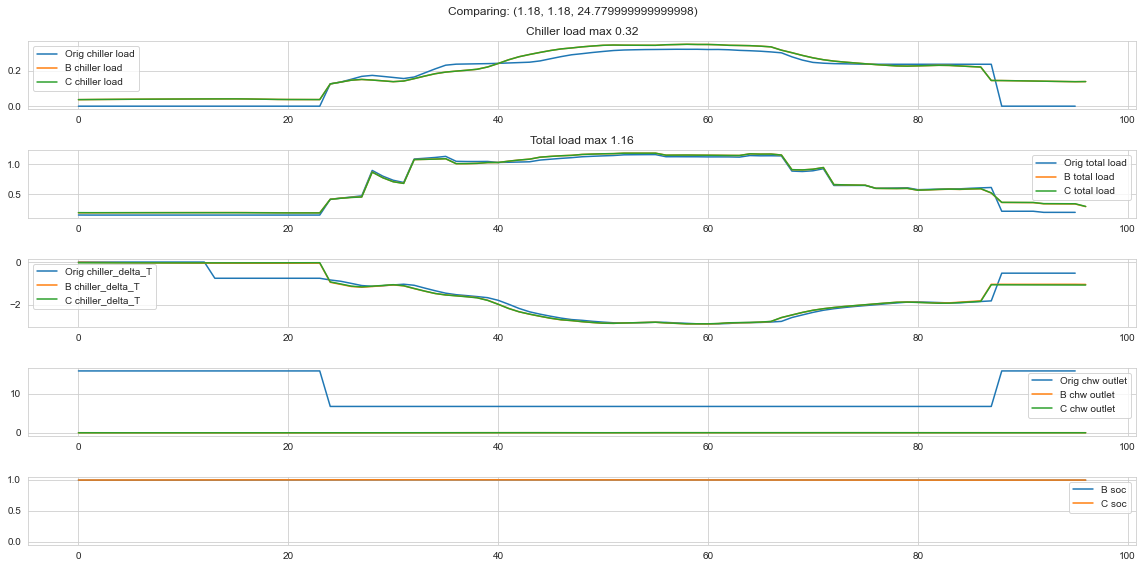

In [ ]:
# Try solving with no TES

m, orig_data = make_model(df, start_ts, peak_tou_mult, mins_per_ts=mins_per_ts, run_fbbt=True)

# initialize the TES and chiller's temp at time = -1 and load up the initial state variables into MPC
prev_outlet_temp = chw_outlet_temp[0] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=1, inlet_temp_mult=0, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=1, tank_flow_fraction_mult=10)
init_data = init_model(df, m, start_ts, prev_outlet_temp, obj_close, socs=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=5, binary_enforce_2=10, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


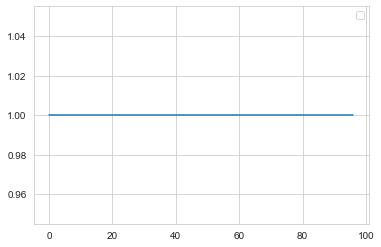

In [ ]:
# plt.plot([value(m.block[i].evap_diff[0])  for i in m.time])
plt.plot([value(m.block[i].tank_flow_fraction[0])  for i in m.time])
# plt.plot(orig_data['chiller_p'] / KW_SCALING, label='old')
plt.legend()
# value(m.block[0].outlet_settemp[-1]), value(m.block[0].outlet_settemp[0])
# chw_outlet_temp[0]

# Original 15-min Optimization

In [ ]:
start_ts = 0
peak_tou_mult = 20
dt_hr = 1 / 4
mins_per_ts = int(60 * dt_hr)

chiller_schedule = make_chiller_schedule(dt_hr)
df_resampled, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T = get_resampled_df(df_orig, dt_hr)
df_15min, loop_inlet, chw_outlet_temp, evap_T_diff, chiller_delta_T, zerod_i = smooth_df(df_resampled)

m, orig_data = make_model(df_15min, start_ts, peak_tou_mult, mins_per_ts=15)
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=1, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
init_data = init_model(df_15min, m, start_ts, prev_outlet_temp, obj_close, socs=None)

plot_comparison(m, orig_data, init_data, set_c=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=0, binary_enforce_2=100, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

Init (0.95, 0.9, 18.95)
First IPOPT solve (0.95, 0.9, 18.95) 19.039151857821928
Second IPOPT solve (0.95, 0.9, 18.95) 19.039151855530083
BONMIN solve (0.95, 0.9, 18.95)


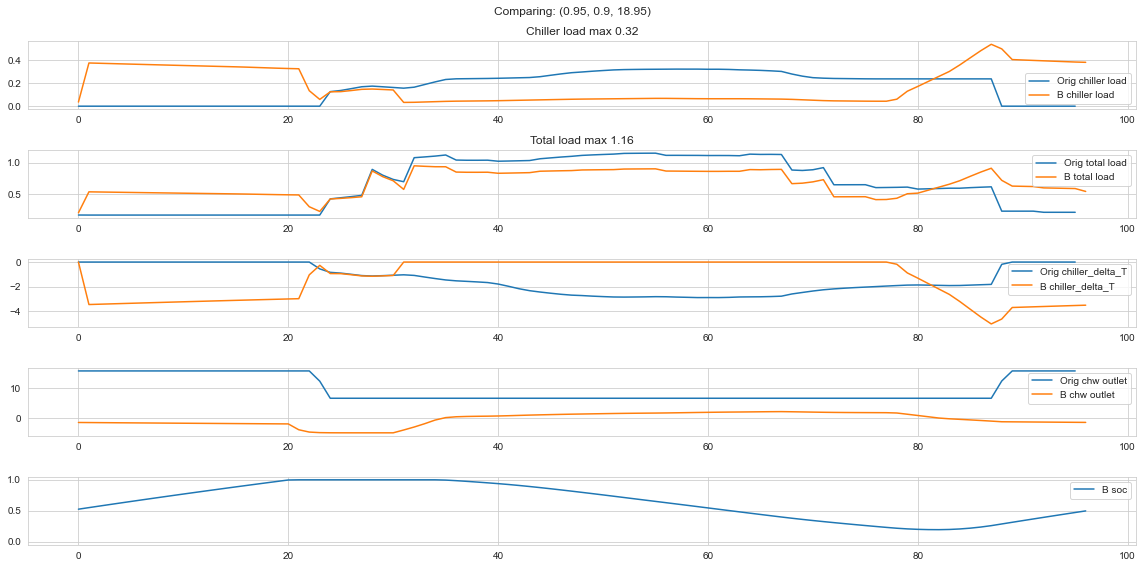

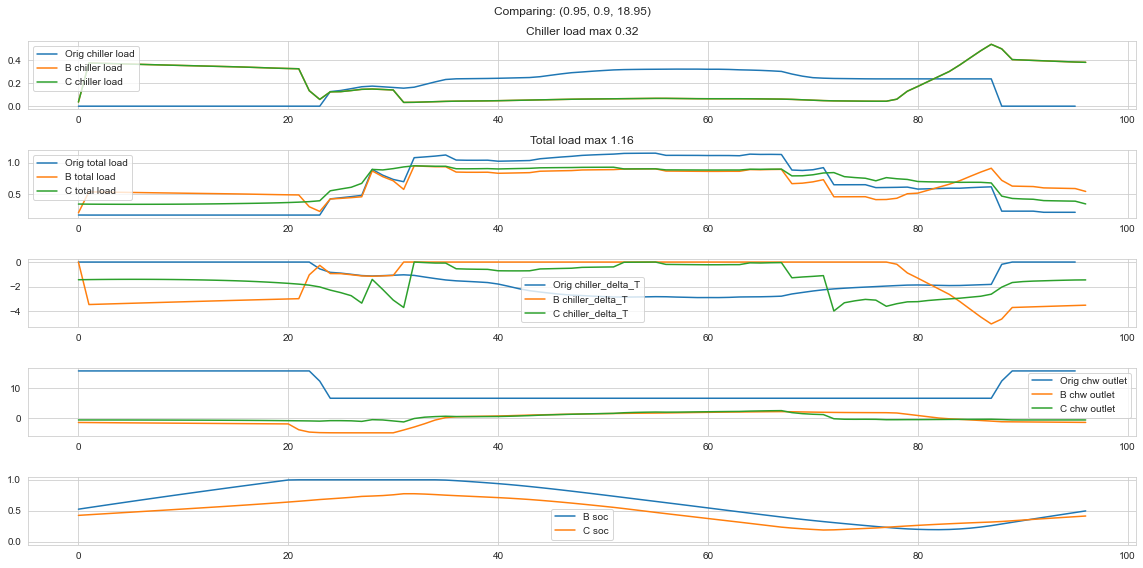

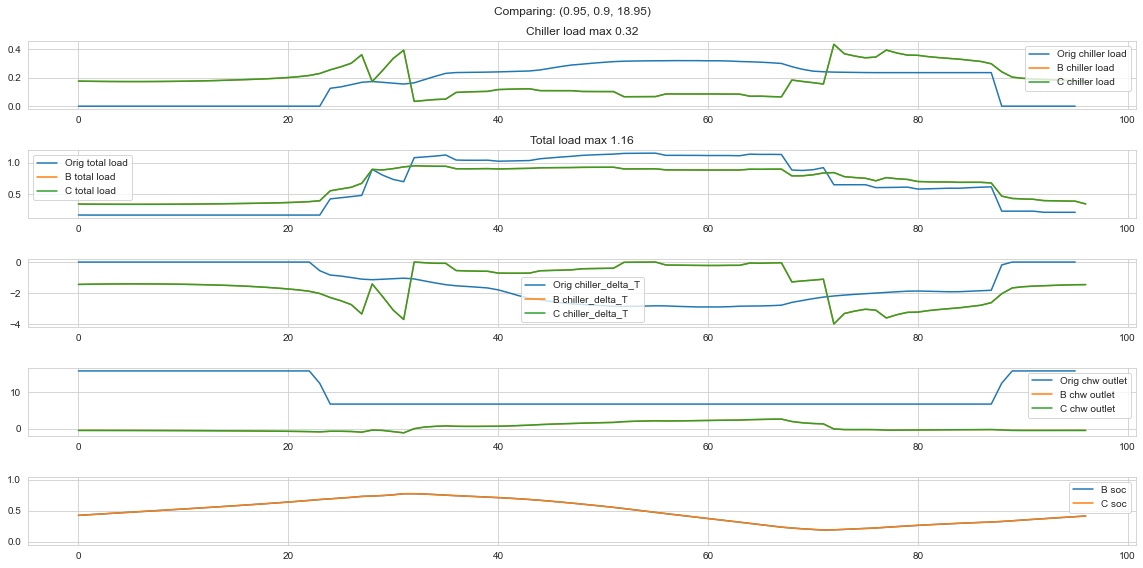

In [ ]:
m, orig_data = make_model(df_15min, start_ts, peak_tou_mult, mins_per_ts=15)
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=1, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
init_data = init_model(df_15min, m, start_ts, prev_outlet_temp, obj_close, socs=None)

plot_comparison(m, orig_data, init_data, set_c=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=0, binary_enforce_2=100, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)

print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

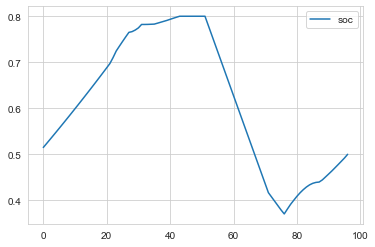

In [ ]:
# m_ip = m.clone()
socs = make_soc(m, start_ts, init_data['chiller_p'], init_data['bldg_p'], 11, 18)

Init (0.95, 0.9, 18.95)
First IPOPT solve (0.95, 0.9, 18.95) 19.039151857821906
Second IPOPT solve (0.95, 0.9, 18.95) 19.03915185553017
BONMIN solve (0.95, 0.9, 18.95)


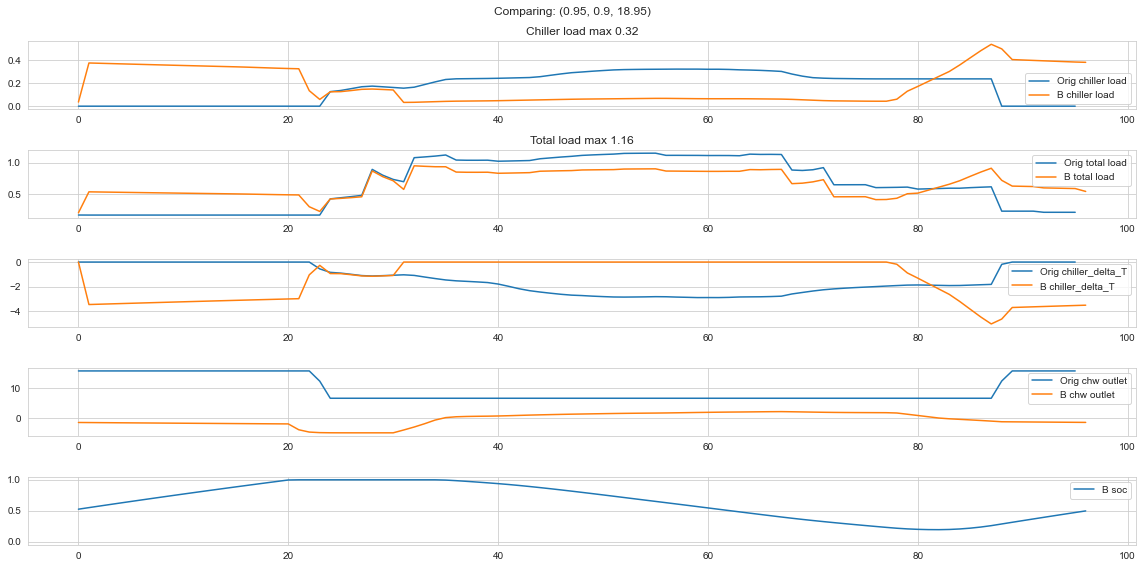

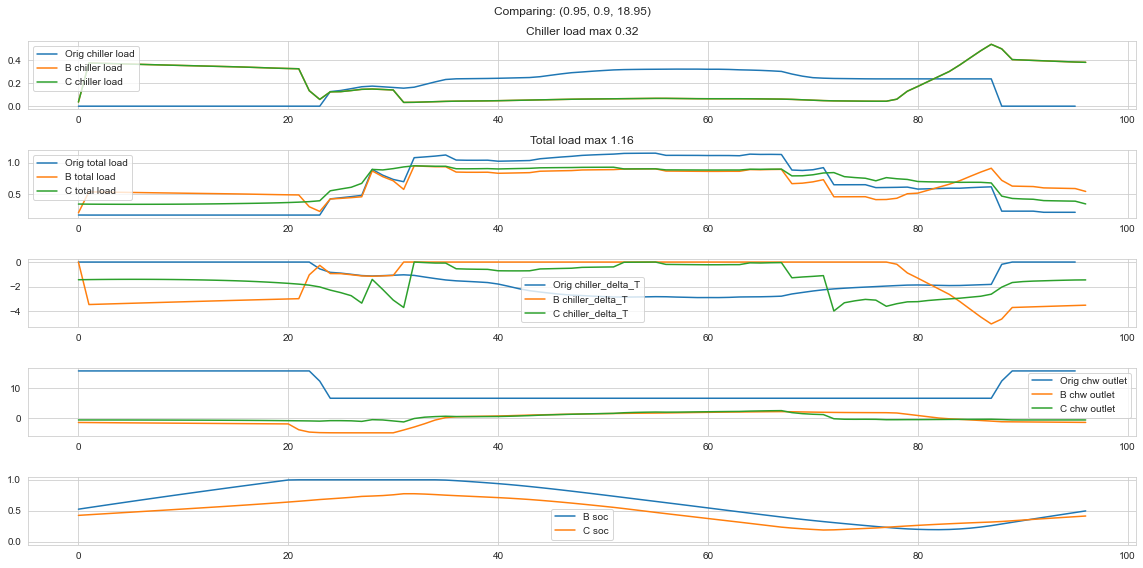

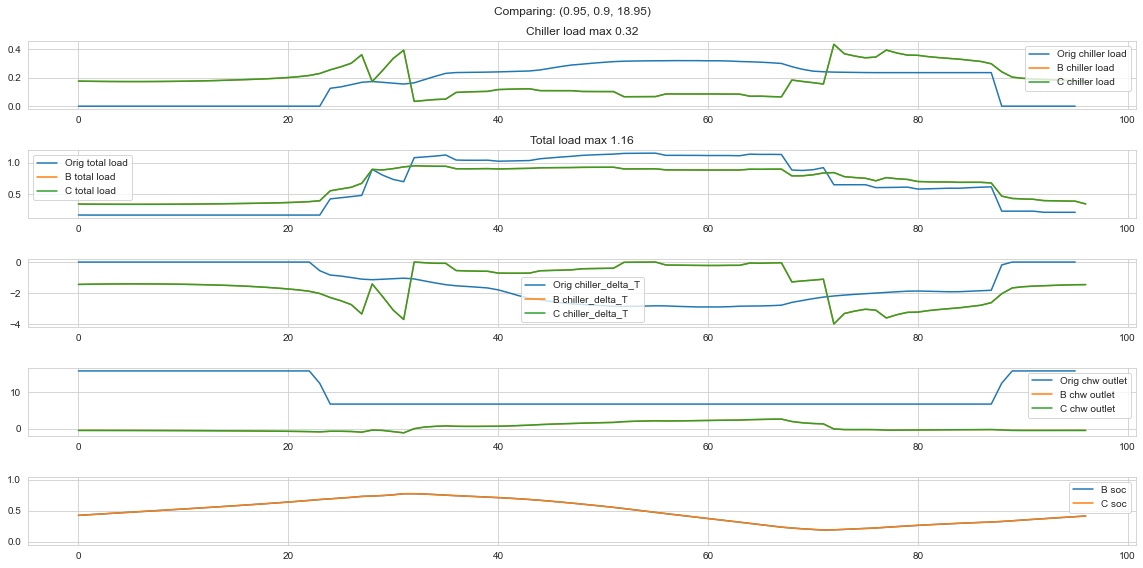

In [ ]:
m, orig_data = make_model(start_ts, peak_tou_mult, mins_per_ts=15)
prev_outlet_temp = chiller_schedule[len(chiller_schedule) - 1] + 273.15

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=1, soc_mult=0, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
init_data = init_model(m, start_ts, prev_outlet_temp, obj_close, socs=None)

plot_comparison(m, orig_data, init_data, set_c=None)
print("Init", calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=0, binary_enforce_2=100, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)
print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

(1.17, 0.92, 19.57)
First IPOPT solve (0.95, 0.9, 18.95) 19.039151857821942
Second IPOPT solve (0.95, 0.9, 18.95) 219.03915186917118
BONMIN solve (0.95, 0.9, 18.95)


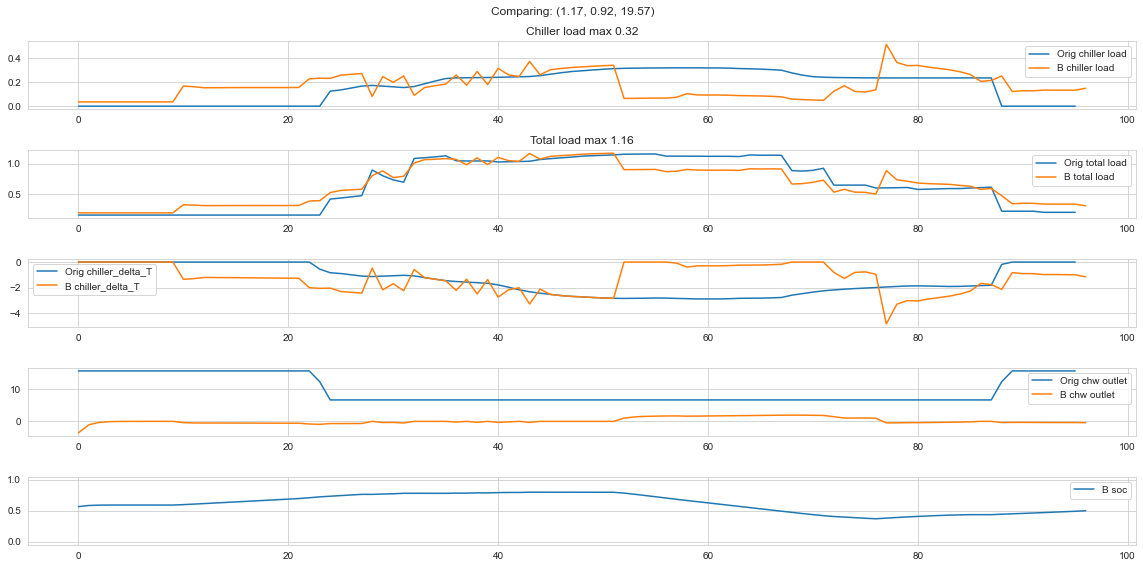

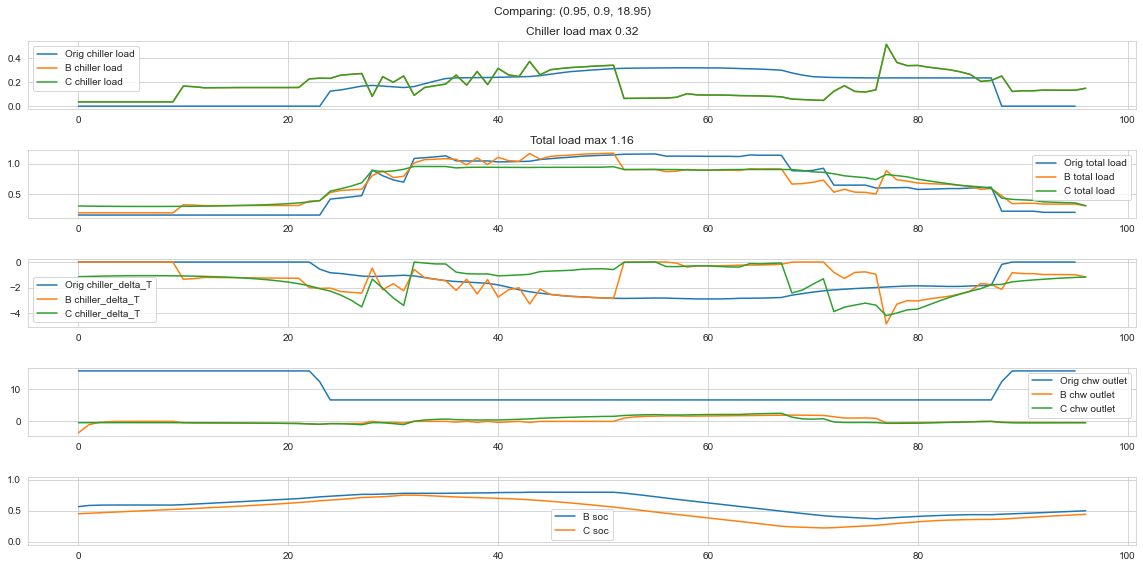

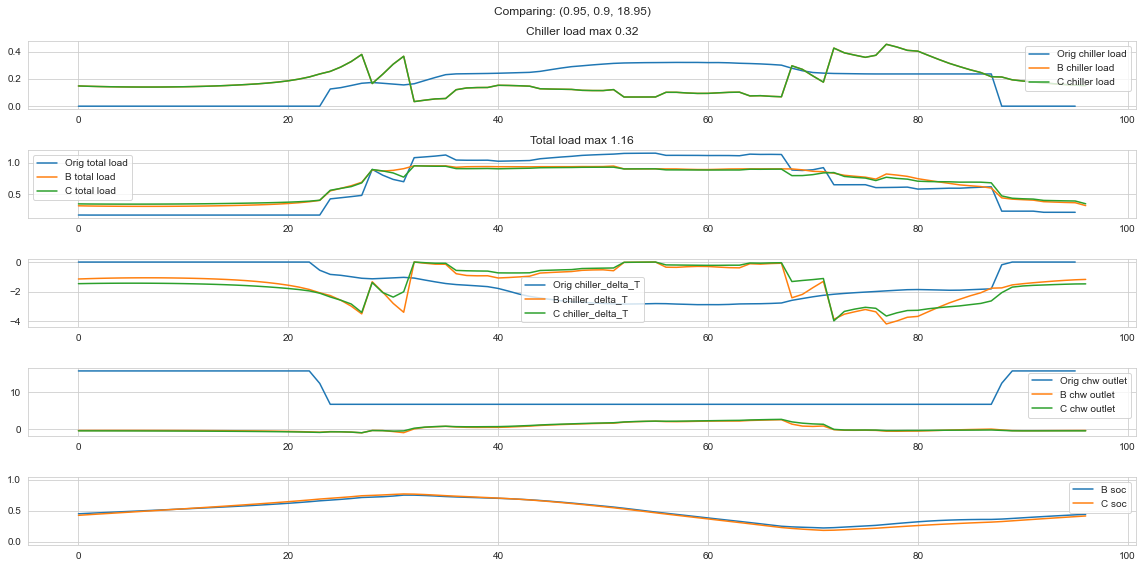

In [ ]:
m, orig_data = make_model(start_ts, peak_tou_mult)

prev_outlet_temp = relaxed_data['chw_outlet_temp'][-1]

obj_close = partial(init_obj, outlet_settemp_mult=0, inlet_temp_mult=0, soc_mult=1, chiller_power=0, 
    tank_flow_fraction=0, tank_flow_fraction_mult=0)
init_data = init_model(m, start_ts, prev_outlet_temp, obj_close, socs=socs)

plot_comparison(m, orig_data, init_data, set_c=None)
print(calc_peak_obj(m))

relaxed_data = solve_relaxed_model(m, binary_enforce=0, deriv_enforce=0, binary_enforce_2=100, socs=None, socs_mult=0)
plot_comparison(m, orig_data, init_data, set_c=relaxed_data)

bonmin_solver.solve(m)
sol_data = get_data(m)
print("BONMIN solve", calc_peak_obj(m))
plot_comparison(m, orig_data, relaxed_data, set_c=sol_data)

In [ ]:
from pyomo.util.infeasible import log_close_to_bounds
solve_log = idaeslog.getInitLogger("infeasibility", idaeslog.INFO, tag="properties")
log_close_to_bounds(m, logger=solve_log, tol=1e-9)